**`Run the following cell to install lyricsgenius:`**

In [1]:
#!pip install lyricsgenius

**`Run the following cell to install spotipy:`**

In [21]:
#!pip install spotipy

**`Import Packages:`**

In [1]:
import boto3
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from Spotify_Analysis import *
import transformers as hf
from torch.utils.data import Dataset, DataLoader
import gensim.downloader
import spotipy 
from spotipy.oauth2 import SpotifyClientCredentials
import pickle

%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings("ignore")

# `Calculating Similarity between Ay-Yo! User Profiles`
`Marti Heit and Emma Rainer`

## Task 1: Create Similarity Metric for Ay-Yo! Users based on Song Lyrics

### `Genius API`
Leverage genius API to scrape relevant song lyrics. Using glove embeddings, find a word vector centroid for the text of a particular song.

In [2]:
genius = Genius(GENIUS_API_TOKEN) # Token stored in Spotify_Analysis.py

### `Profile Similarity of Ay-Yo users`

#### Pull Users and Posts from Ay-Yo!

In [3]:
with open('aws_access_key.txt', 'r') as f:
     AWS_ACCESS_KEY = f.read().split('\n')[0]
with open('aws_secret_access_key.txt', 'r') as f:
     AWS_SECRET_ACCESS_KEY = f.read().split('\n')[0]

users_to_posts = get_users_to_posts(AWS_ACCESS_KEY, AWS_SECRET_ACCESS_KEY)

In [19]:
users_to_lyrics = get_users_to_lyrics(users_to_posts, GENIUS_API_TOKEN)

Searching for "Forever After All" by Luke Combs...
Done.
Searching for "Being In Love" by Wet Leg...
Done.
Searching for "Last Caress - C.I. Recording 1978" by Misfits...
No results found for: 'Last Caress - C.I. Recording 1978 Misfits'
Searching for "Ribs" by Lorde...
Done.
Searching for "blue" by keshi...
Done.
Searching for "I Gotta Feeling" by Black Eyed Peas...
Done.
Searching for "I Love You." by Kaivon...
Done.
Searching for "Violent Crimes" by Kanye West...
Done.
Searching for "Do It To It" by ACRAZE...
Done.
Searching for "Set Me Free (feat. MAX)" by Oliver Heldens...
Done.
Searching for "less of you" by keshi...
Done.
Searching for "Down with the Sickness" by Disturbed...
Done.
Searching for "she likes spring, I prefer winter" by slchld...
Done.
Searching for "Ghost" by Justin Bieber...
Done.
Searching for "Places We Don't Know" by Kasbo...
Specified song does not contain lyrics. Rejecting.
Searching for "September" by Earth, Wind & Fire...
Done.
Searching for "Viva La Vida" 

#### Generate Fake Users for Validation

In [22]:
users_to_lyrics['Kanye West'] = get_song_list('Kanye West', GENIUS_API_TOKEN, 10)
users_to_lyrics['Kid Cudi'] = get_song_list('Kid Cudi', GENIUS_API_TOKEN, 10)
users_to_lyrics['Big Sean'] = get_song_list('Big Sean', GENIUS_API_TOKEN, 10)
users_to_lyrics['A$AP Rocky'] = get_song_list('A$AP Rocky', GENIUS_API_TOKEN, 10)
users_to_lyrics['Pusha T'] = get_song_list('Pusha T', GENIUS_API_TOKEN, 10)
users_to_lyrics['The Wiggles'] = get_song_list('The Wiggles', GENIUS_API_TOKEN, 10)

Searching for songs by Kanye West...

Song 1: "Mercy"
Searching for songs by Kanye West...

Song 1: "Mercy"
Song 2: "Father Stretch My Hands, Pt. 1"
Song 3: "Monster"
Song 4: "Ultralight Beam"
Song 5: "Bound 2"
Song 6: "New Slaves"
Song 7: "Blood on the Leaves"
Song 8: "Black Skinhead"
Song 9: "Runaway"
Song 10: "No More Parties In LA"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by Kid Cudi...

Song 1: "Just What I Am"
Song 2: "Pursuit of Happiness (Nightmare)"
Song 3: "Day ‘N’ Nite (Nightmare)"
Song 4: "Soundtrack 2 My Life"
Song 5: "Mr. Rager"
Song 6: "The Prayer"
Song 7: "Erase Me"
Song 8: "Man on the Moon (The Anthem)"
Song 9: "King Wizard"
Song 10: "By Design"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by Big Sean...

Song 1: "Control"
Song 2: "I Don’t Fuck with You"
Song 3: "Blessings"
Song 4: "Bounce Back"
Song 5: "Beware"
Song 6: "Dance (A$$) (Remix)"
Song 7: "No Favors"
Song 8: "I Know"
Song 9: "One

#### Reload Dictionary 

In [24]:
# file = open("users_to_lyrics.pkl", "wb")
# pickle.dump(users_to_lyrics, file)
# file.close()

In [4]:
file = open("users_to_lyrics.pkl", "rb")
users_to_lyrics_dict = pickle.load(file)

In [5]:
users_to_lyrics = users_to_lyrics_dict.copy()

#### Define Dataset

In [6]:
class AyyoDataset(Dataset):
    def __init__(self, users_to_lyrics, word_embedding, tokenizer):
        self.users_to_lyrics = users_to_lyrics
        self.word_emb = word_embedding
        self.tokenizer = tokenizer
        
    def __len__(self):
        return len(self.users_to_lyrics)
    
    def __getitem__(self, idx):
        if isinstance(idx, int):
            key = list(self.users_to_lyrics.keys())[idx]
        else:
            key = idx
        lyrics_list = self.users_to_lyrics[key]
        centroid = compute_centroid(lyrics_list, self.word_emb, self.tokenizer)
        return key, centroid

In [7]:
user2idx = {u:i for i, u in enumerate(list(users_to_lyrics.keys()))}

### `Calculating Similarity`

$$\text {similarity score = }\frac 1 {\lVert \vec u_i - \vec u_j \rVert}$$

#### Using Pretrained GloVe Embeddings with Custom Tokenization

In [101]:
glove = load_glove('glove.6B.300d.txt')  # dictionary

In [102]:
dataset = AyyoDataset(users_to_lyrics, glove, tokenizer=None)
dataloader = DataLoader(dataset)

In [103]:
user1, centroid1 = dataset[12]
user2, centroid2 = dataset[15]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Similarity score between emmamnrainer and marti.heit is 2.932515774938386


In [104]:
user1, centroid1 = dataset[user2idx['trenthamner']]
user2, centroid2 = dataset[user2idx['marti.heit']]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Similarity score between trenthamner and marti.heit is 1.4218806279754908


In [105]:
user1, centroid1 = dataset[user2idx['mateen_saifyan']]
user2, centroid2 = dataset[user2idx['marti.heit']]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Similarity score between mateen_saifyan and marti.heit is 3.1848293441693714


In [106]:
user1, centroid1 = dataset[user2idx['mateen_saifyan']]
user2, centroid2 = dataset[user2idx['emmamnrainer']]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Similarity score between mateen_saifyan and emmamnrainer is 2.311618790213754


In [107]:
user1, centroid1 = dataset[user2idx['Kanye West']]
user2, centroid2 = dataset[user2idx['Pusha T']]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Similarity score between Kanye West and Pusha T is 2.441083945463712


In [108]:
user1, centroid1 = dataset[user2idx['Kanye West']]
user2, centroid2 = dataset[user2idx['The Wiggles']]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Similarity score between Kanye West and The Wiggles is 0.8747930103806878


> #### Initial Observations
> - Similarity between Ay-Yo! users is quite high
>- Similarity between similar artists is high
>- Similarity between non-similar artists is low 

#### Using Pretrained GloVe Embeddings with Pretrained Autotokenizer 

In [8]:
tokenizer = hf.AutoTokenizer.from_pretrained('bert-base-uncased')

In [19]:
dataset = AyyoDataset(users_to_lyrics, glove, tokenizer=tokenizer)
dataloader = DataLoader(dataset)

In [20]:
user1, centroid1 = dataset[12]
user2, centroid2 = dataset[15]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Token indices sequence length is longer than the specified maximum sequence length for this model (842 > 512). Running this sequence through the model will result in indexing errors


Similarity score between emmamnrainer and marti.heit is 4.85455328419959


In [21]:
user1, centroid1 = dataset[user2idx['trenthamner']]
user2, centroid2 = dataset[user2idx['marti.heit']]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Similarity score between trenthamner and marti.heit is 2.2158771756560953


In [22]:
user1, centroid1 = dataset[user2idx['mateen_saifyan']]
user2, centroid2 = dataset[user2idx['marti.heit']]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Similarity score between mateen_saifyan and marti.heit is 5.393656290567637


In [23]:
user1, centroid1 = dataset[user2idx['mateen_saifyan']]
user2, centroid2 = dataset[user2idx['emmamnrainer']]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Similarity score between mateen_saifyan and emmamnrainer is 4.251840166878206


In [24]:
user1, centroid1 = dataset[user2idx['Kanye West']]
user2, centroid2 = dataset[user2idx['Pusha T']]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Similarity score between Kanye West and Pusha T is 3.6074956761462285


In [25]:
user1, centroid1 = dataset[user2idx['Kanye West']]
user2, centroid2 = dataset[user2idx['The Wiggles']]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Similarity score between Kanye West and The Wiggles is 1.41452491056156


> #### Observations
> - Trends are the same as before, but differences are more pronounced

#### Using Wikipedia GloVe Embeddings with Pretrained Autotokenizer

In [9]:
wiki_emb = gensim.downloader.load('glove-wiki-gigaword-100')

In [10]:
dataset = AyyoDataset(users_to_lyrics, wiki_emb, tokenizer=tokenizer)
dataloader = DataLoader(dataset)

In [11]:
user1, centroid1 = dataset[12]
user2, centroid2 = dataset[15]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Token indices sequence length is longer than the specified maximum sequence length for this model (842 > 512). Running this sequence through the model will result in indexing errors


Similarity score between emmamnrainer and marti.heit is 6.031296767831677


In [29]:
user1, centroid1 = dataset[user2idx['trenthamner']]
user2, centroid2 = dataset[user2idx['marti.heit']]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Similarity score between trenthamner and marti.heit is 2.570535760660875


In [30]:
user1, centroid1 = dataset[user2idx['mateen_saifyan']]
user2, centroid2 = dataset[user2idx['marti.heit']]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Similarity score between mateen_saifyan and marti.heit is 6.5895859605959455


In [31]:
user1, centroid1 = dataset[user2idx['mateen_saifyan']]
user2, centroid2 = dataset[user2idx['emmamnrainer']]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Similarity score between mateen_saifyan and emmamnrainer is 5.6360329248659


In [32]:
user1, centroid1 = dataset[user2idx['Kanye West']]
user2, centroid2 = dataset[user2idx['Pusha T']]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Similarity score between Kanye West and Pusha T is 4.138384085050752


In [33]:
user1, centroid1 = dataset[user2idx['Kanye West']]
user2, centroid2 = dataset[user2idx['The Wiggles']]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Similarity score between Kanye West and The Wiggles is 1.5429937150739725


#### Using Twitter GloVe Embeddings with Pretrained Autotokenizer

In [34]:
import gensim.downloader
glove_emb = gensim.downloader.load('glove-twitter-200')

In [35]:
dataset = AyyoDataset(users_to_lyrics, glove_emb, tokenizer=tokenizer)
dataloader = DataLoader(dataset)

In [36]:
user1, centroid1 = dataset[12]
user2, centroid2 = dataset[15]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Similarity score between emmamnrainer and marti.heit is 4.598116953244766


In [37]:
user1, centroid1 = dataset[user2idx['trenthamner']]
user2, centroid2 = dataset[user2idx['marti.heit']]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Similarity score between trenthamner and marti.heit is 2.1478190514230704


In [38]:
user1, centroid1 = dataset[user2idx['mateen_saifyan']]
user2, centroid2 = dataset[user2idx['marti.heit']]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Similarity score between mateen_saifyan and marti.heit is 5.16914736278516


In [39]:
user1, centroid1 = dataset[user2idx['mateen_saifyan']]
user2, centroid2 = dataset[user2idx['emmamnrainer']]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Similarity score between mateen_saifyan and emmamnrainer is 3.8491131289041687


In [40]:
user1, centroid1 = dataset[user2idx['Kanye West']]
user2, centroid2 = dataset[user2idx['Pusha T']]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Similarity score between Kanye West and Pusha T is 3.060854893774542


In [41]:
user1, centroid1 = dataset[user2idx['Kanye West']]
user2, centroid2 = dataset[user2idx['The Wiggles']]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Similarity score between Kanye West and The Wiggles is 1.3176041729903967


>#### Observations
>- Differences seem less pronounced with Twitter embedding than with Wikipedia embedding
>- In general, autotokenization seems to give more pronouced differences than word tokenization

### `Final Algorithm Choice`

- Pretrained subword autotokenization
- Pretrained GloVe Wikipedia embeddings

In [12]:
dataset = AyyoDataset(users_to_lyrics, wiki_emb, tokenizer=tokenizer)
dataloader = DataLoader(dataset)

### `Validating Results`

In [113]:
kanye_similarities = {artist: similarity_score(dataset[user2idx['Kanye West']][1], dataset[user2idx[artist]][1])\
                     for artist in ['Pusha T', 'Big Sean', 'A$AP Rocky', 'Kid Cudi', 'The Wiggles']}

Token indices sequence length is longer than the specified maximum sequence length for this model (2035 > 512). Running this sequence through the model will result in indexing errors


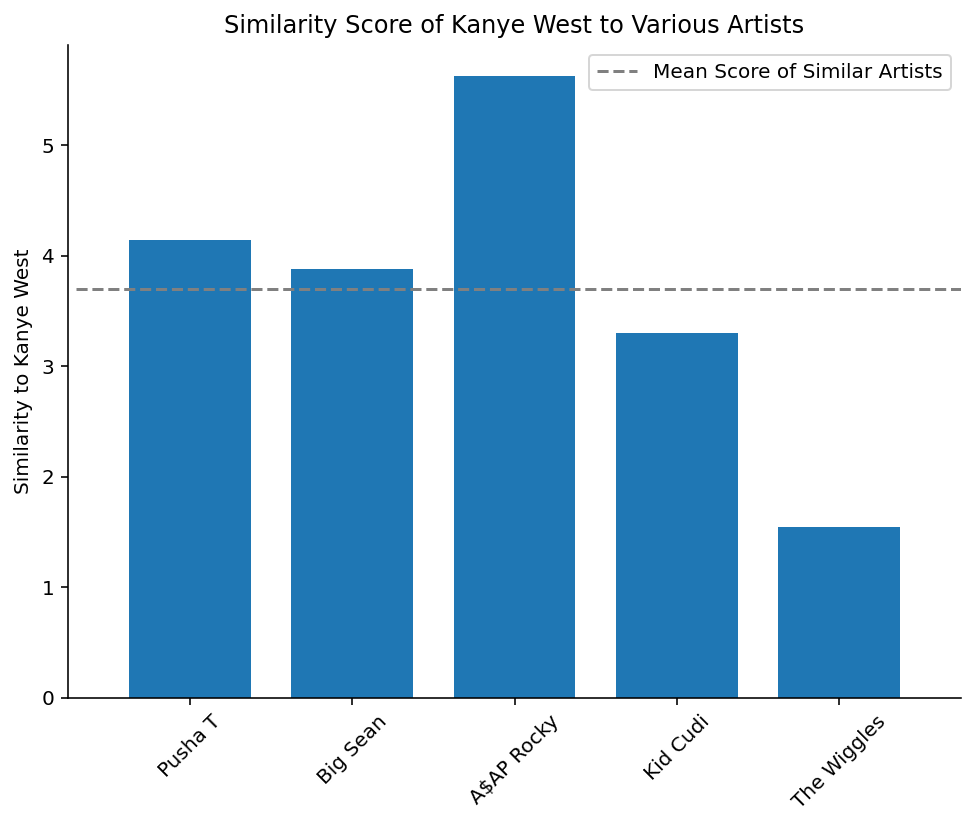

In [114]:
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlim(-0.75, 4.75)
plt.bar(x=kanye_similarities.keys(),height=[v for v in kanye_similarities.values()], width=0.75)
plt.hlines(np.mean([v for v in kanye_similarities.values()]), xmin=-0.7, xmax=4.75,
          color='grey', linestyle='dashed', label='Mean Score of Similar Artists')
plt.xticks(rotation = 45)
plt.title('Similarity Score of Kanye West to Various Artists')
plt.ylabel('Similarity to Kanye West')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend()
plt.savefig('kanye_barchart.png', bbox_inches='tight', pad_inches=0.1)

### `Find Most Similar Users`

In [115]:
get_most_similar_users('marti.heit', dataset)[1:5]

[('mateen_saifyan', 6.587588482646844),
 ('yuuknowwhoitis', 6.115434583479382),
 ('31lve7qlslqnsxb6byqkmqbdqgsu', 6.0877398681321155),
 ('emmamnrainer', 6.031296767831677)]

In [116]:
get_most_similar_users('marti.heit', dataset)[-1]

('1210490048', 0.9182736568046612)

In [46]:
user_similarity_matrix = create_user_similarity_matrix(users_to_lyrics, dataset)

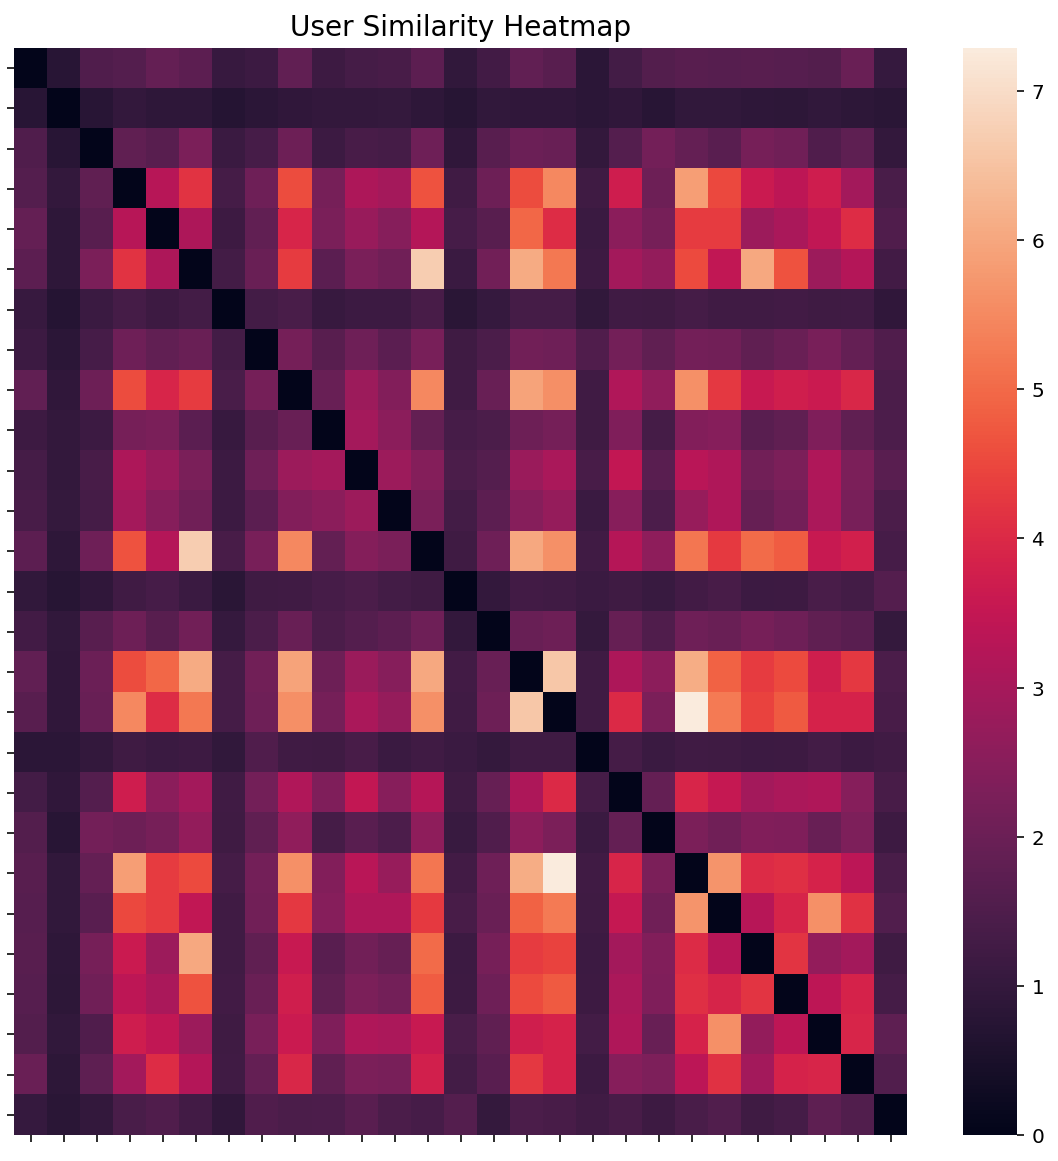

In [90]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(user_similarity_matrix.astype('float64'))
ax.set_title('User Similarity Heatmap', size=14)
ax.set(xticklabels=[], yticklabels=[])
fig.show()
plt.savefig('user_heatmap_no_label.png', bbox_inches='tight', pad_inches=0.1)

## Task 2: Use Ay-Yo! User Embeddings to Predict if a User Will Like a Song

### `Retrieve Additional Song Features from Spotify`

Leverage Spotify API to retrieve the following features for each Ay-Yo! post:
- energy
- loudness
- danceability
- speechiness

#### Retrieve Spotify URIs for each Ay-Yo! post

Spotify URIs allow us to retrieve song features using the Spotify API

In [13]:
with open('spotify_client_id.txt', 'r') as f:
     SPOTIFY_CLIENT_ID = f.read().split('\n')[0]
with open('spotify_secret_id.txt', 'r') as f:
     SPOTIFY_SECRET_ID = f.read().split('\n')[0]

In [14]:
uris = get_users_to_spotify_uri(AWS_ACCESS_KEY, AWS_SECRET_ACCESS_KEY)

#### Use Spotify API to gather song features

In [15]:
song_info = get_uri_to_song_info(SPOTIFY_CLIENT_ID,SPOTIFY_SECRET_ID, uris)

In [16]:
user_to_song_info = song_info.copy()

### `Retrieve Data from Negative Class`

`Idea`: We are using implicit feedback as the target variable. In order to create a balanced dataset, we need to create negative data. Instead of randomly choosing songs to assign to the negative, we are assigning the songs posted by the most dissimilar Ay-Yo! user to be in the negative class for a given user.

#### Get Songs from Least Similar User

In [17]:
users = list(song_info.keys())

In [145]:
user_to_neg_songs = {u: [] for u in users}
for user in users:
    least_similar_user = get_least_similar_users(user, dataset)[1][0]
    print(least_similar_user)
    negative_songs_info = song_info[least_similar_user]
    user_to_neg_songs[user] = [least_similar_user, negative_songs_info]

natalieferrer
ihsrumaaonj0jmbtkpqq9s0p5
ihsrumaaonj0jmbtkpqq9s0p5
natalieferrer
natalieferrer
ihsrumaaonj0jmbtkpqq9s0p5
ihsrumaaonj0jmbtkpqq9s0p5
0o2zvlqg9lssoqqjs2lse8wyr
natalieferrer
31ucdexwlncddxmliey5osk6ivhy
31ucdexwlncddxmliey5osk6ivhy
natalieferrer
ihsrumaaonj0jmbtkpqq9s0p5
31ucdexwlncddxmliey5osk6ivhy
ihsrumaaonj0jmbtkpqq9s0p5
natalieferrer
natalieferrer
1210490048
ihsrumaaonj0jmbtkpqq9s0p5
ihsrumaaonj0jmbtkpqq9s0p5
natalieferrer


### `Generate Dataframe`

- users_to_lyrics
- user_to_neg_songs # negative songs
- user_to_song_info # positive songs

#### Drop Fake Users

In [120]:
fake_users = ['Kanye West','Kid Cudi','Big Sean','A$AP Rocky','Pusha T','The Wiggles']
for fake_user in fake_users:
    users_to_lyrics.pop(fake_user)

#### Add 'Positive' Song Class

In [122]:
data = {}
for key, value in users_to_lyrics.items():
    song_features = user_to_song_info[key]
    for i in range(len(value)):
        user, centroid = dataset[user2idx[key]]
        data[value[i]] = [user, centroid, song_features[i]]

In [123]:
spotify_df = pd.DataFrame.from_dict(data, orient='index').reset_index()

In [127]:
spotify_df['rating']=1
spotify_df = spotify_df.rename(columns={"index": "text", 2:'song_feat', 1: "centroid", 0:'user'})
spotify_df = spotify_df[spotify_df.text.apply(len)!=0].reset_index(drop=True)
spotify_df.head()

,text,user,centroid,song_feat,rating
0,Forever After All Lyrics[Verse 1]\nA cold beer...,0o2zvlqg9lssoqqjs2lse8wyr,"[-0.056197487, 0.27977416, 0.38032714, -0.3473...","[0.65, -5.195, 0.487, 0.0253]",1
1,Being in Love Lyrics[Verse 1]\nI need a lie do...,1210490048,"[-0.09963894, 0.20158978, 0.3310916, -0.239551...","[0.687, -4.94, 0.716, 0.0342]",1
2,Ribs Lyrics[Verse 1]\nThe drink you spilt all ...,12178001444,"[-0.11929899, 0.29106337, 0.46630117, -0.41031...","[0.472, -9.277, 0.511, 0.091]",1
3,"​blue Lyrics[Chorus]\nImpatient, just say it\n...",1251007470,"[-0.14268215, 0.24018188, 0.44452268, -0.41008...","[0.563, -8.689, 0.513, 0.0338]",1
4,I Gotta Feeling Lyrics[Intro: will.i.am]\nI go...,yuuknowwhoitis,"[-0.13550940114830426, 0.2203946017127538, 0.4...","[0.766, -6.375, 0.744, 0.0265]",1


In [129]:
#spotify_df.to_pickle('spotify_df.pkl')

In [132]:
# spotify_df = pd.read_pickle("spotify_df.pkl")  

#### Add 'Negative' Song Class Using Negative Sampling

In [171]:
negative_data = {}
for key, value in user_to_neg_songs.items():
    user = key
    neg_user = value[0]
    song_features = value[1]
    neg_song_text = users_to_lyrics[neg_user]
    for i in range(len(neg_song_text)):
        user, centroid = dataset[user2idx[key]]
        negative_data[(neg_song_text[i], user)] = [centroid, song_features[i]]

In [239]:
negative_spotify_df = pd.DataFrame.from_dict(negative_data, orient='index').reset_index()
negative_spotify_df['rating']=0
negative_spotify_df = negative_spotify_df.rename(columns={1:'song_feat', 0: "centroid"})
negative_spotify_df[['text', 'user']] = pd.DataFrame(negative_spotify_df['index'].tolist(),\
                                                     index=negative_spotify_df.index)
negative_spotify_df = negative_spotify_df.drop(columns='index')
negative_spotify_df = negative_spotify_df[negative_spotify_df.text.apply(len)!=0].reset_index(drop=True)
negative_spotify_df.head()

,centroid,song_feat,rating,text,user
0,"[-0.056197487, 0.27977416, 0.38032714, -0.3473...","[0.469, -7.282, 0.373, 0.0415]",0,Changes Lyrics[Verse 1]\nI feel unhappy\nI fee...,0o2zvlqg9lssoqqjs2lse8wyr
1,"[-0.056197487, 0.27977416, 0.38032714, -0.3473...","[0.344, -8.613, 0.84, 0.0374]",0,"Remember Me Lyrics[Spoken Intro]\nPlease, allo...",0o2zvlqg9lssoqqjs2lse8wyr
2,"[-0.056197487, 0.27977416, 0.38032714, -0.3473...","[0.159, -14.461, 0.83, 0.0383]",0,"Fuentes de Ortiz Lyrics[Letra de ""Fuentes de O...",0o2zvlqg9lssoqqjs2lse8wyr
3,"[-0.056197487, 0.27977416, 0.38032714, -0.3473...","[0.668, -4.483, 0.549, 0.0255]",0,Honey Bones Lyrics[Verse 1]\nThe post hasn't m...,0o2zvlqg9lssoqqjs2lse8wyr
4,"[-0.09963894, 0.20158978, 0.3310916, -0.239551...","[0.877, -6.51, 0.714, 0.067]",0,"Vacation Lyrics[Intro]\nJust fly me out, fly m...",1210490048


#### Concatenate to Create DataFrame

In [245]:
frames = [spotify_df, negative_spotify_df]

In [250]:
df = pd.concat(frames).sample(frac=1)
df.head()

,text,user,centroid,song_feat,rating
42,"7 rings Lyrics[Verse 1]\nYeah, breakfast at Ti...",31lve7qlslqnsxb6byqkmqbdqgsu,"[-0.10023554, 0.25210622, 0.4115456, -0.383116...","[0.317, -10.732, 0.778, 0.334]",1
166,Today’s Top Hits 7/9/21 (feat. Post Malone) Ly...,marti.heit,"[-0.10762603, 0.23826009, 0.41644016, -0.38233...","[0.862, -3.424, 0.824, 0.126]",1
58,"Take a Bow Lyrics[Intro]\nOh, how about a roun...",lazertx,"[-0.18217811, 0.22827205, 0.4236892, -0.399270...","[0.467, -7.536, 0.697, 0.0715]",0
151,Short Skirt/Long Jacket Lyrics[Verse 1]\nI wan...,marti.heit,"[-0.10762603, 0.23826009, 0.41644016, -0.38233...","[0.899, -6.552, 0.778, 0.0451]",1
119,Love in the Dark Lyrics[Verse 1]\nTake your ey...,emmamnrainer,"[-0.111197054, 0.23873831, 0.42647716, -0.3976...","[0.341, -6.057, 0.331, 0.0309]",1


### `Define Dataset`

In [258]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [251]:
dataset = AyyoDataset(users_to_lyrics, wiki_emb, tokenizer=tokenizer)
dataloader = DataLoader(dataset)

In [359]:
class SpotifyDataset(Dataset):
    def __init__(self, df, word_embedding, tokenizer):
        self.word_emb = word_embedding
        self.tokenizer = tokenizer
        self.df = df
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Song Lyric Embedding - Shape (100,)
        lyrics = row['text']
        text = doc2vec(lyrics, self.word_emb, self.tokenizer)
        
        # User Ay-Yo! History Embedding - Shape (100,)
        centroid = row['centroid']
        
        # Energy, Loudness, Danceability, Speechiness Embedding- Shape (4,)
        song_feat = row['song_feat']
        
        row_embedding = np.concatenate((text,centroid,song_feat))
        
        x = torch.tensor(row_embedding).float()
        y = torch.tensor(row['rating'])

        return x, y

In [414]:
from sklearn.model_selection import train_test_split
df_train, df_valid = train_test_split(df, test_size=0.21)
train_ds = SpotifyDataset(df_train, wiki_emb, tokenizer=tokenizer)
valid_ds = SpotifyDataset(df_valid, wiki_emb, tokenizer=tokenizer)

train_dl = DataLoader(train_ds, batch_size=2)
valid_dl = DataLoader(valid_ds, batch_size=5)

### `Modeling`

#### Define Two Layer Vanilla Neural Network

`Idea`: Start with something simple. If it works, then no need to complicate the model.

In [415]:
class Song_Pred_NN(nn.Module):
    def __init__(self, hidden_dim):
        super(Song_Pred_NN, self).__init__()
        
        # initialize the layers with random weights
        self.linear1 = nn.Linear(204, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return torch.squeeze(x)

In [481]:
# Make sure model works as expected
model = Song_Pred_NN(100)
x, y = next(iter(train_dl))
model(x).shape

torch.Size([2])

#### Training Loop

In [473]:
def one_pass(model, dataloader, optimizer, lossFun, backwards=True, print_loss=False):
    
    if backwards == True:
        model.train()
    else:
        model.eval()
    
    total_loss = 0.0
    for x, y in tqdm(dataloader):
        
        y_pred = model(x)
        loss = lossFun(y_pred, y.float())
        total_loss += loss.item()
        
        if backwards == True:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    avg_loss = total_loss / len(dataloader)
    
    if print_loss == True:
        print(avg_loss)
    
    return avg_loss

def one_pass_metrics(model, dataloader):
    model.eval()
    acc = 0.0
    prec = 0.0
    recall = 0.0
        
    for x, y in tqdm(dataloader):
        y_pred = (torch.sigmoid(model(x)) > 0.5).long()
        total_correct = torch.sum(y == y_pred).item()
        total_true_pos = torch.sum(torch.logical_and(y == 1, y == y_pred)).item()        
        
        threshold = 1e-15
        acc += total_correct / (y.nelement()+threshold)
        prec += total_true_pos / (torch.sum(y_pred).item()+threshold)
        recall += total_true_pos / (torch.sum(y).item()+threshold)
    
    acc = acc / len(dataloader)
    prec = prec / len(dataloader)
    recall = recall / len(dataloader)
    
    return acc, prec, recall

In [478]:
from tqdm.notebook import tqdm

def train_model(model, train_dl, valid_dl, optimizer, lossFun, num_epochs = 20):

    train_losses = []
    val_losses = []
    for epoch in tqdm(range(num_epochs)):
        print('Epoch: ', epoch)

        loss = one_pass(model, train_dl, optimizer, lossFun)
        train_losses.append(loss)
        print('Train Loss: ', loss)

        loss = one_pass(model, valid_dl, optimizer, lossFun, backwards=False)
        val_losses.append(loss)
        print('Validation Loss: ', loss)
    
        if epoch % 5 == 0:
            acc, prec, recall = one_pass_metrics(model, train_dl)
            print('Train Accuracy: ', acc, 'Train Precision: ', prec,'Train Recall: ', recall)

            acc, prec, recall = one_pass_metrics(model, valid_dl)
            print('Val Accuracy: ', acc, 'Val Precision: ', prec,'Val Recall: ', recall)

    return train_losses, val_losses

#### Baseline Model Metrics

In [506]:
model = Song_Pred_NN(100)
lossFun = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(Spotify_model.parameters(), lr = 0.001)

In [507]:
baseline_loss = one_pass(model, train_dl, optimizer, lossFun, backwards=False, print_loss=False)
print('Baseline Training Loss:', baseline_loss)

  0%|          | 0/120 [00:00<?, ?it/s]

Baseline Training Loss: 0.6995499809583028


In [508]:
baseline_val_loss = one_pass(model, valid_dl, optimizer, lossFun, backwards=False, print_loss=False)
print('Baseline Validation Loss:', baseline_val_loss)

  0%|          | 0/13 [00:00<?, ?it/s]

Baseline Validation Loss: 0.6943359420849726


> #### Observations: 
> - A loss of 0.69 for a binary cross-entropy means that the model is not learning anything. 
> - log(2) = 0.69... model is no better than a random coin flip, as expected

### `Grid Search`

In [479]:
import torch.optim as optim

In [480]:
train_loss_dict = {}
val_loss_dict = {}
for hs in [50, 100, 150]:
    Spotify_model = Song_Pred_NN(hs)
    # feeds outputs through a sigmoid before computing BCE Loss
    lossFun = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(Spotify_model.parameters(), lr = 0.001)
    train_loss, val_loss = train_model(Spotify_model, train_dl, valid_dl, optimizer, lossFun)
    
    train_loss_dict[hs] = train_loss
    val_loss_dict[hs] = val_loss
    

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch:  0


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.5771801980833212


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.7072193324565887


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.7583333333333332 Train Precision:  0.7583333333333332 Train Recall:  0.9333333333333332


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.5846153846153844 Val Precision:  0.5846153846153844 Val Recall:  0.9999999999999998
Epoch:  1


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.5513129465281963


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.6842194130787482
Epoch:  2


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.5403176788240671


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.6631456430141742
Epoch:  3


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.5295929305255413


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.644527446765166
Epoch:  4


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.5201213431855043


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.6266029041547042
Epoch:  5


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.5115071561187505


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.6113836604815263


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.7833333333333332 Train Precision:  0.7833333333333332 Train Recall:  0.9291666666666666


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.723076923076923 Val Precision:  0.6846153846153845 Val Recall:  0.9999999999999998
Epoch:  6


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.5021348394453525


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5966343306578122
Epoch:  7


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.492206363628308


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5816282309018649
Epoch:  8


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.48284288396437963


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5642505402748401
Epoch:  9


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.4714826670785745


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5507731162584745
Epoch:  10


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.4597964044039448


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5379698826716497


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.8041666666666666 Train Precision:  0.8041666666666666 Train Recall:  0.9249999999999999


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.723076923076923 Val Precision:  0.6846153846153845 Val Recall:  0.9999999999999998
Epoch:  11


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.4480865871533751


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5253209127829626
Epoch:  12


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.43549164390812317


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5132360802246974
Epoch:  13


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.4238650813077887


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5018613132146689
Epoch:  14


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.41226538649449745


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4899062399680798
Epoch:  15


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.4009551138927539


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.483508825302124


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.8874999999999998 Train Precision:  0.8749999999999999 Train Recall:  0.9124999999999999


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.7999999999999999 Val Precision:  0.7551282051282051 Val Recall:  0.9999999999999998
Epoch:  16


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3887948837131262


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4746026626000038
Epoch:  17


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.37859012096499406


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.46444090742331284
Epoch:  18


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3673279159081479


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4591778746018043
Epoch:  19


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3571338255579273


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4492831551111661


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch:  0


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.5752187171330054


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.7053564672286694


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.7583333333333332 Train Precision:  0.7583333333333332 Train Recall:  0.9333333333333332


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.5846153846153844 Val Precision:  0.5846153846153844 Val Recall:  0.9999999999999998
Epoch:  1


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.5524915859103203


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.6882243133508242
Epoch:  2


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.5407892247041066


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.6611217122811538
Epoch:  3


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.530030348772804


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.639289949948971
Epoch:  4


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.5194026103864113


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.6188965623195355
Epoch:  5


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.5083962118873994


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5992489273731525


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.7833333333333332 Train Precision:  0.7833333333333332 Train Recall:  0.9291666666666666


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.723076923076923 Val Precision:  0.6846153846153845 Val Recall:  0.9999999999999998
Epoch:  6


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.4971363888432582


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.578841908619954
Epoch:  7


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.48528456867982944


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5616095639192141
Epoch:  8


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.47083676140755415


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5408644653283633
Epoch:  9


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.45659452931334576


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.521908700466156
Epoch:  10


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.44203069570163883


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5063367944497329


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.8291666666666665 Train Precision:  0.8333333333333333 Train Recall:  0.9166666666666665


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.7538461538461539 Val Precision:  0.705128205128205 Val Recall:  0.9999999999999998
Epoch:  11


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.4272787179797888


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4962034844435178
Epoch:  12


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.41251036267106733


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.48602653925235456
Epoch:  13


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3974952843040228


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.47484981555205125
Epoch:  14


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3829649876492719


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.46587847287838274
Epoch:  15


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.36991563852255543


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.45506246044085574


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9166666666666665 Train Precision:  0.8833333333333332 Train Recall:  0.8916666666666665


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.8153846153846153 Val Precision:  0.8205128205128205 Val Recall:  0.9423076923076921
Epoch:  16


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.35673769113297266


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.44984816014766693
Epoch:  17


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3445274033894142


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.43878181737202865
Epoch:  18


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.33337881915892165


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4349462894292978
Epoch:  19


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3227005858439952


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4273306761796658


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch:  0


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.5778487209230662


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.6951562555936667


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.7583333333333332 Train Precision:  0.7583333333333332 Train Recall:  0.9333333333333332


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.5846153846153844 Val Precision:  0.5846153846153844 Val Recall:  0.9999999999999998
Epoch:  1


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.5507617261260748


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.6717463273268479
Epoch:  2


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.5383196484297514


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.6505738152907445
Epoch:  3


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.5275732606649399


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.6238478124141693
Epoch:  4


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.5177089211841425


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.6055499980082879
Epoch:  5


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.5067038138707479


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5864712733488816


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.7833333333333332 Train Precision:  0.7833333333333332 Train Recall:  0.9291666666666666


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.723076923076923 Val Precision:  0.6846153846153845 Val Recall:  0.9999999999999998
Epoch:  6


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.494121411939462


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5661894679069519
Epoch:  7


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.48005841970443724


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5468407250367678
Epoch:  8


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.46616365686058997


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5274668083741114
Epoch:  9


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.4499593595663706


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5091106249735906
Epoch:  10


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.433298933878541


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.49292704463005066


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.8541666666666665 Train Precision:  0.8416666666666666 Train Recall:  0.9166666666666665


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.7538461538461539 Val Precision:  0.705128205128205 Val Recall:  0.9999999999999998
Epoch:  11


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.4179930660563211


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4778175101830409
Epoch:  12


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.40203567991654077


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4664338964682359
Epoch:  13


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3863412661788364


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4539784238888667
Epoch:  14


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.37096250200023256


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4422827477638538
Epoch:  15


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3562255293130875


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4279906405852391


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9166666666666665 Train Precision:  0.8916666666666665 Train Recall:  0.8833333333333332


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.8307692307692307 Val Precision:  0.8269230769230768 Val Recall:  0.9423076923076921
Epoch:  16


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.34269086432953677


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4169092889015491
Epoch:  17


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3295302759700765


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4149131362254803
Epoch:  18


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.31849179340836903


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.40344916169460004
Epoch:  19


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.30645586528504887


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.39650425200278944


#### Plot Loss

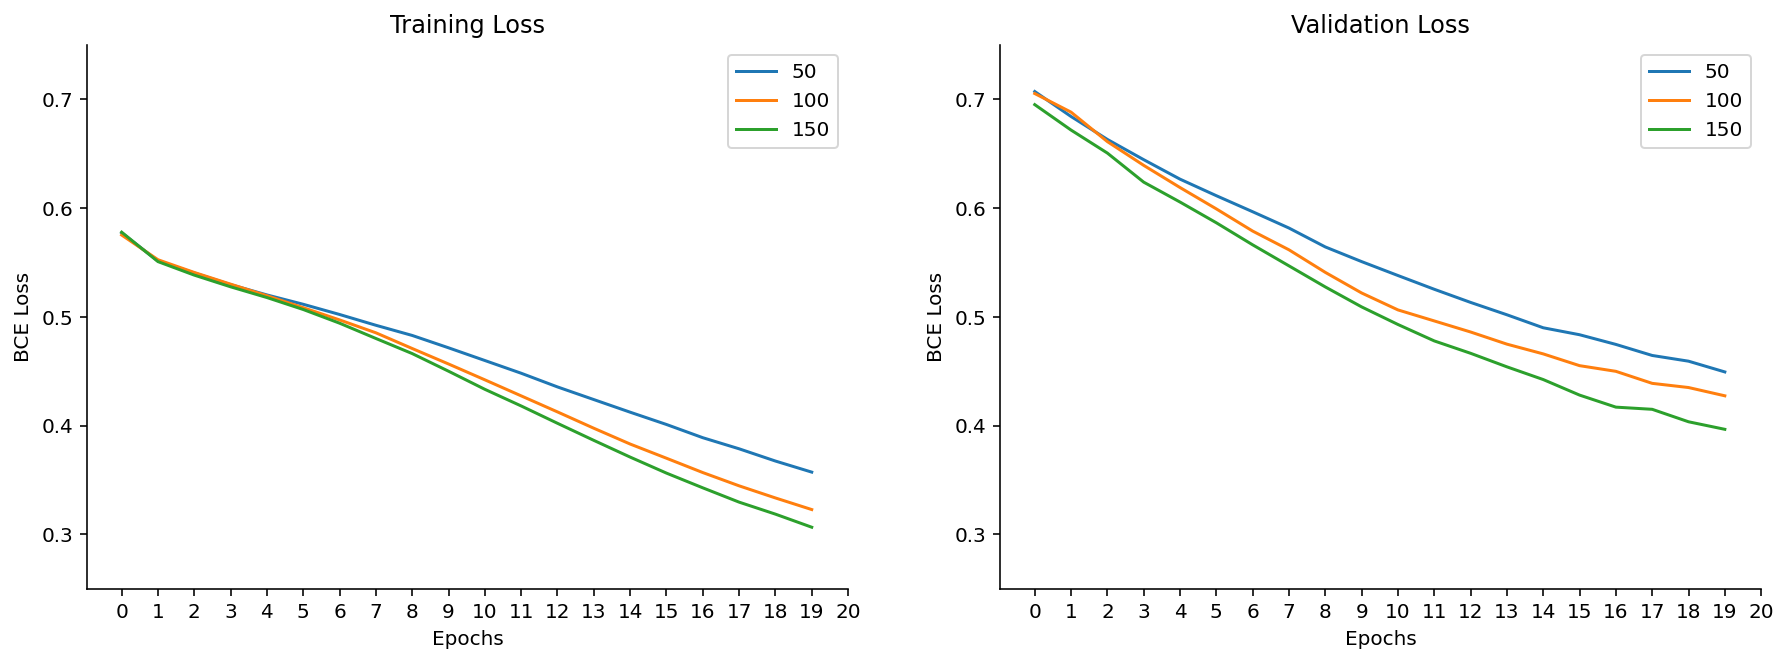

In [568]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].plot(train_loss_dict[50], label = '50')
axs[1].plot(val_loss_dict[50], label = '50')

axs[0].plot(train_loss_dict[100], label = '100')
axs[1].plot(val_loss_dict[100], label = '100')

axs[0].plot(train_loss_dict[150], label = '150')
axs[1].plot(val_loss_dict[150], label = '150')

axs[0].legend()
axs[1].legend()

axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('BCE Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('BCE Loss')

axs[0].set_ylim([0.25,0.75])
axs[1].set_ylim([0.25,0.75])

axs[0].set_xticks(np.arange(21))
axs[1].set_xticks(np.arange(21))

axs[0].set_title('Training Loss')
axs[1].set_title('Validation Loss')

# Hide the right and top spines
axs[0].spines.right.set_visible(False)
axs[0].spines.top.set_visible(False)
axs[1].spines.right.set_visible(False)
axs[1].spines.top.set_visible(False)

plt.show()

> #### Observations: 
> - A greater hidden size improves model performance on both training and test set.
> - Loss continues to decrease after 10 epochs, try training for longer

#### Continued Training

In [549]:
Spotify_model = Song_Pred_NN(150)

# feeds outputs through a sigmoid before computing BCE Loss
lossFun = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(Spotify_model.parameters(), lr = 0.001)
train_loss, val_loss = train_model(Spotify_model, train_dl, valid_dl, optimizer, lossFun, num_epochs=75)    

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch:  0


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.5749919194728136


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.6940553119549384


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.7583333333333332 Train Precision:  0.7583333333333332 Train Recall:  0.9333333333333332


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.5846153846153844 Val Precision:  0.5846153846153844 Val Recall:  0.9999999999999998
Epoch:  1


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.5503210579355557


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.6687215039363275
Epoch:  2


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.5379726216197014


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.6455273834558634
Epoch:  3


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.5267377836008866


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.624775061240563
Epoch:  4


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.5169023497651021


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.6056012304929587
Epoch:  5


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.5055843013028304


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5881183514228234


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.7833333333333332 Train Precision:  0.7833333333333332 Train Recall:  0.9291666666666666


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.723076923076923 Val Precision:  0.6846153846153845 Val Recall:  0.9999999999999998
Epoch:  6


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.4938927501440048


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.565028231877547
Epoch:  7


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.48033596531798445


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5452626897738531
Epoch:  8


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.46714383630702894


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5282996526131263
Epoch:  9


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.45180997606366874


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5109958465282733
Epoch:  10


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.43605409196267525


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4966841454689319


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.8541666666666665 Train Precision:  0.8374999999999999 Train Recall:  0.9166666666666665


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.7692307692307693 Val Precision:  0.7307692307692307 Val Recall:  0.9999999999999998
Epoch:  11


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.4208268233885368


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.48265551374508786
Epoch:  12


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.40395627270142237


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.46912964949241054
Epoch:  13


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3892571003486713


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4588356889211215
Epoch:  14


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3737152589174608


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4467338564304205
Epoch:  15


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.35971180045356355


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4390582832006308


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9249999999999999 Train Precision:  0.8916666666666665 Train Recall:  0.8916666666666665


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.8307692307692307 Val Precision:  0.8269230769230768 Val Recall:  0.9423076923076921
Epoch:  16


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3469477366656065


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.42949211024321043
Epoch:  17


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.33379807346500456


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4215496973349498
Epoch:  18


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3222408969110499


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.40893332545573896
Epoch:  19


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3106433460333695


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4024246037006378
Epoch:  20


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.2997982688713819


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.39816436859277576


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9041666666666666 Train Precision:  0.8916666666666665 Train Recall:  0.8583333333333332


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.846153846153846 Val Precision:  0.8397435897435896 Val Recall:  0.9423076923076921
Epoch:  21


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.28965604994446037


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.38767510652542114
Epoch:  22


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.2789768749382347


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3792344033718109
Epoch:  23


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.2703226330302035


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.37415036215231967
Epoch:  24


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.2632268748789405


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3644709787689723
Epoch:  25


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.25427999985404315


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.36276326787013274


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9083333333333332 Train Precision:  0.8958333333333333 Train Recall:  0.8666666666666666


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.8615384615384614 Val Precision:  0.8653846153846152 Val Recall:  0.9423076923076921
Epoch:  26


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.24835113449177396


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.36379507871774525
Epoch:  27


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.2397596080477039


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.35582207716428316
Epoch:  28


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.23387649895157664


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.35889400656406695
Epoch:  29


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.22871668263105677


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.35858311561437756
Epoch:  30


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.22417570360315342


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.35059406665655285


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9291666666666666 Train Precision:  0.9041666666666666 Train Recall:  0.8749999999999999


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.8769230769230768 Val Precision:  0.8846153846153845 Val Recall:  0.9423076923076921
Epoch:  31


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.2195328352972865


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.36073297090255296
Epoch:  32


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.21267799772322177


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3432369673481354
Epoch:  33


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.20656798257647704


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3495704084634781
Epoch:  34


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.20286424335402747


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3519725472881244
Epoch:  35


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.19729333514696917


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3325962728032699


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9249999999999999 Train Precision:  0.9041666666666666 Train Recall:  0.8666666666666666


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.8923076923076922 Val Precision:  0.9038461538461537 Val Recall:  0.9423076923076921
Epoch:  36


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.19280338966636917


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.34557513491465497
Epoch:  37


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.18930306998663582


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3451059890481142
Epoch:  38


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.18342525702513132


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3323253754239816
Epoch:  39


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.1800099308292071


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.33728765696287155
Epoch:  40


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.1752597448377249


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.32030863945300764


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9416666666666665 Train Precision:  0.9166666666666665 Train Recall:  0.8833333333333332


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.9076923076923078 Val Precision:  0.9076923076923075 Val Recall:  0.9615384615384612
Epoch:  41


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.17343770656443666


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3344859847655663
Epoch:  42


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.16932575700047892


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.32886481514343846
Epoch:  43


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.1668569337130369


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3326944846373338
Epoch:  44


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.16285022456140724


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.330877070243542
Epoch:  45


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.16023678666970226


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.34235722514299244


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9416666666666665 Train Precision:  0.9124999999999999 Train Recall:  0.8749999999999999


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.8923076923076921 Val Precision:  0.9012820512820512 Val Recall:  0.9358974358974356
Epoch:  46


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.15935240211159302


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3367651076270984
Epoch:  47


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.15431573030364235


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3468083613193952
Epoch:  48


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.14959008796261816


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3185776225649394
Epoch:  49


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.14913082501346556


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.31520087300584865
Epoch:  50


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.14586218689170588


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.31978323195989317


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9416666666666665 Train Precision:  0.9166666666666665 Train Recall:  0.8833333333333332


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.9076923076923075 Val Precision:  0.9397435897435893 Val Recall:  0.9358974358974356
Epoch:  51


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.14343247492676406


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.32473000368246663
Epoch:  52


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.14222052327507603


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3323066948124996
Epoch:  53


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.13964671916667915


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3446541099021068
Epoch:  54


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.1361082464985278


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3290285339149145
Epoch:  55


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.13438887086255516


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.31621077255560803


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9458333333333332 Train Precision:  0.9166666666666665 Train Recall:  0.8874999999999998


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.9076923076923075 Val Precision:  0.9397435897435893 Val Recall:  0.9358974358974356
Epoch:  56


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.13342537754372946


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.33804417573488676
Epoch:  57


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.13050921881234293


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3175638753634233
Epoch:  58


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.12865130263465593


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3332192089695197
Epoch:  59


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.12633212679623587


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.33008991898252416
Epoch:  60


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.1260816869749154


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.32975634645957214


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9458333333333332 Train Precision:  0.9166666666666665 Train Recall:  0.8833333333333332


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.9384615384615385 Val Precision:  0.9807692307692305 Val Recall:  0.9358974358974356
Epoch:  61


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.1230341911192833


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3142373547531091
Epoch:  62


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.1229303677771289


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.33500545357282346
Epoch:  63


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.11955090760196375


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.33107678305644256
Epoch:  64


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.11707039013281247


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3374070949279345
Epoch:  65


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.11552358143829528


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.33285340236929745


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9583333333333333 Train Precision:  0.9166666666666665 Train Recall:  0.8958333333333333


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.9076923076923075 Val Precision:  0.9294871794871791 Val Recall:  0.9358974358974356
Epoch:  66


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.11481056344518947


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3261920998875911
Epoch:  67


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.11313435628198931


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3329140695814903
Epoch:  68


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.11189430718319879


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3300469053479341
Epoch:  69


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.10671516919464921


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3366850734903262
Epoch:  70


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.10392706781514487


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.32423970045951694


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9583333333333333 Train Precision:  0.9208333333333332 Train Recall:  0.9083333333333332


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.9076923076923078 Val Precision:  0.9205128205128201 Val Recall:  0.9615384615384612
Epoch:  71


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.10668448392774128


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3367256330182919
Epoch:  72


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.10513041642328365


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.33079068477337176
Epoch:  73


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.10139292186034557


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3291575494580544
Epoch:  74


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.10002927224239405


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3286449850465243


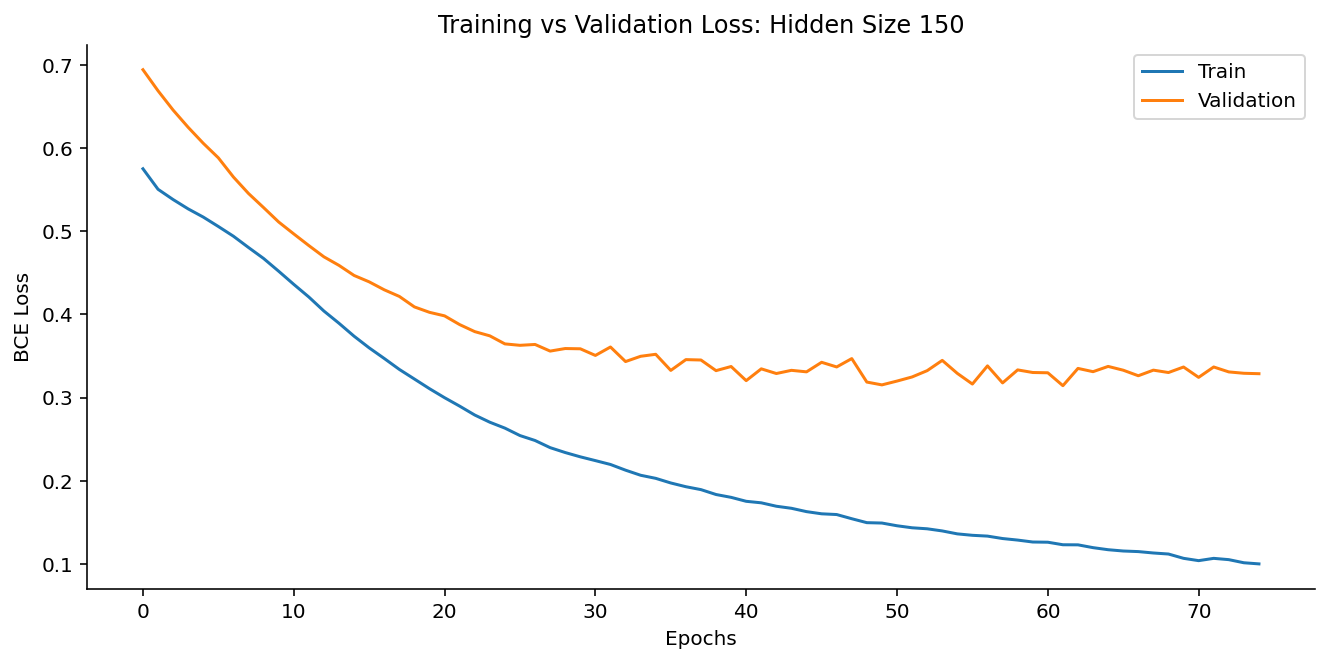

In [569]:
fig, ax = plt.subplots(figsize=(11,5))
ax.plot(train_loss, label = 'Train')
ax.plot(val_loss, label = 'Validation')
ax.set_title('Training vs Validation Loss: Hidden Size 150')
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_xlabel('Epochs')
ax.set_ylabel('BCE Loss')
ax.legend()
plt.show()

> #### Observations: 
> - Model begins to overfit to training data
> - Validation loss oscillates around 0.33
> - Some regularization technique needed to make model more generalizable

#### Tuning

In [570]:
Spotify_model_with_wd = Song_Pred_NN(150)

# feeds outputs through a sigmoid before computing BCE Loss
lossFun = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(Spotify_model_with_wd.parameters(), lr = 0.001, weight_decay=0.01)
train_loss_wd, val_loss_wd = train_model(Spotify_model_with_wd, train_dl, valid_dl, optimizer, lossFun, num_epochs=75)    


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch:  0


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.5767192694048087


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.6907308330902686


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.7583333333333332 Train Precision:  0.7583333333333332 Train Recall:  0.9333333333333332


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.5846153846153844 Val Precision:  0.5846153846153844 Val Recall:  0.9999999999999998
Epoch:  1


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.5598271902650594


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.674704916202105
Epoch:  2


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.5538981148352226


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.6722912788391113
Epoch:  3


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.5501778112103541


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.6657668122878442
Epoch:  4


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.5474962161233028


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.6616083452334771
Epoch:  5


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.5455378955850999


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.6569757232299218


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.7541666666666665 Train Precision:  0.7583333333333332 Train Recall:  0.9291666666666666


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.6153846153846152 Val Precision:  0.6038461538461537 Val Recall:  0.9999999999999998
Epoch:  6


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.543714432666699


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.6532949690635388
Epoch:  7


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.5421616435050964


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.6514077049035293
Epoch:  8


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.5405731773624818


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.6492173281999735
Epoch:  9


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.5397344615310431


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.6456470902149494
Epoch:  10


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.5382303560773531


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.641506362419862


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.7749999999999999 Train Precision:  0.7791666666666666 Train Recall:  0.9291666666666666


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.6307692307692305 Val Precision:  0.6153846153846152 Val Recall:  0.9999999999999998
Epoch:  11


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.5376420713961124


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.6365801462760339
Epoch:  12


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.5358526706695557


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.6365622350802789
Epoch:  13


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.5343474424133698


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.6344341475229996
Epoch:  14


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.5334833754847447


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.62743885242022
Epoch:  15


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.531774249797066


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.6282546382683974


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.7749999999999999 Train Precision:  0.7791666666666666 Train Recall:  0.9291666666666666


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.6461538461538461 Val Precision:  0.6269230769230768 Val Recall:  0.9999999999999998
Epoch:  16


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.5306093831857045


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.6268316965836745
Epoch:  17


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.5286785572767257


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.6228316311652844
Epoch:  18


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.5278408098965883


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.6202917695045471
Epoch:  19


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.5257228076457977


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.6180450457793015
Epoch:  20


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.5252554501096408


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.6154265426672422


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.7833333333333332 Train Precision:  0.7833333333333332 Train Recall:  0.9291666666666666


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.723076923076923 Val Precision:  0.6846153846153845 Val Recall:  0.9999999999999998
Epoch:  21


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.5240422709534566


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.6085672195141132
Epoch:  22


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.5234107701728742


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.6038427513379317
Epoch:  23


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.5202006623148918


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.6060140912349408
Epoch:  24


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.5187644318987926


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.60308327124669
Epoch:  25


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.517252865806222


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5998992919921875


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.7791666666666666 Train Precision:  0.7833333333333332 Train Recall:  0.9249999999999999


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.723076923076923 Val Precision:  0.6846153846153845 Val Recall:  0.9999999999999998
Epoch:  26


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.5160907484591007


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5996198539550488
Epoch:  27


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.5132035331179698


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5945689403093778
Epoch:  28


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.511181864142418


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5934749108094436
Epoch:  29


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.5110101247827212


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5930076058094318
Epoch:  30


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.5091717343777418


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.589921201650913


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.7791666666666666 Train Precision:  0.7833333333333332 Train Recall:  0.9249999999999999


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.723076923076923 Val Precision:  0.6846153846153845 Val Recall:  0.9999999999999998
Epoch:  31


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.506782183671991


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5846047401428223
Epoch:  32


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.5048488155007362


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5810441672801971
Epoch:  33


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.5021784830838442


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5791630722009219
Epoch:  34


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.5002213139086962


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.577899538553678
Epoch:  35


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.4978558752064904


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5733943398182209


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.7791666666666666 Train Precision:  0.7833333333333332 Train Recall:  0.9249999999999999


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.723076923076923 Val Precision:  0.6846153846153845 Val Recall:  0.9999999999999998
Epoch:  36


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.49694916860510907


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5697138745051163
Epoch:  37


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.4950599767267704


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5654189678338858
Epoch:  38


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.49332732359568277


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5698511829743018
Epoch:  39


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.48997152149677276


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5642070472240448
Epoch:  40


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.48792072348296645


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.558181691628236


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.7874999999999999 Train Precision:  0.7874999999999999 Train Recall:  0.9249999999999999


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.723076923076923 Val Precision:  0.6846153846153845 Val Recall:  0.9999999999999998
Epoch:  41


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.48552249937007824


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5613962068007543
Epoch:  42


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.48241532060007253


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5569308652327611
Epoch:  43


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.4800840636094411


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5562200339940878
Epoch:  44


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.4767142460991939


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5504307953210977
Epoch:  45


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.4744394946222504


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5486904176381918


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.7916666666666665 Train Precision:  0.7916666666666665 Train Recall:  0.9249999999999999


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.723076923076923 Val Precision:  0.6846153846153845 Val Recall:  0.9999999999999998
Epoch:  46


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.4722861278802156


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5477982484377347
Epoch:  47


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.4704089197640618


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5449559826117295
Epoch:  48


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.46768909599632025


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5404903040482447
Epoch:  49


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.4646677882721027


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5383551693879641
Epoch:  50


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.46077091538657744


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5348613583124601


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.8083333333333332 Train Precision:  0.8083333333333332 Train Recall:  0.9249999999999999


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.723076923076923 Val Precision:  0.6846153846153845 Val Recall:  0.9999999999999998
Epoch:  51


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.4593762730558713


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5344494374898764
Epoch:  52


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.4561333829537034


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5300425726633805
Epoch:  53


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.45441407108058535


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5295978692861704
Epoch:  54


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.45275027422855296


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5272781298710749
Epoch:  55


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.4492902845144272


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5244673857322106


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.8291666666666665 Train Precision:  0.8249999999999998 Train Recall:  0.9249999999999999


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.7384615384615383 Val Precision:  0.6923076923076923 Val Recall:  0.9999999999999998
Epoch:  56


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.4461387225116293


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5204457984520838
Epoch:  57


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.4439334360261758


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5224103721288534
Epoch:  58


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.4407137733573715


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5216302413206834
Epoch:  59


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.4397286197170615


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.514828065266976
Epoch:  60


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.43561534912635885


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5095121837579287


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.8666666666666666 Train Precision:  0.8499999999999999 Train Recall:  0.9208333333333332


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.769230769230769 Val Precision:  0.7384615384615384 Val Recall:  0.9807692307692305
Epoch:  61


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.43404724498589836


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5115497777095208
Epoch:  62


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.43065102454274895


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5112242950842931
Epoch:  63


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.4285623458524545


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5044736403685349
Epoch:  64


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.42637759608527026


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5081927524163172
Epoch:  65


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.4223518727657696


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5005232577140515


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.8958333333333333 Train Precision:  0.8666666666666666 Train Recall:  0.9208333333333332


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.7538461538461537 Val Precision:  0.7384615384615384 Val Recall:  0.9615384615384612
Epoch:  66


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.4214769020366172


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.504209999854748
Epoch:  67


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.41919067191580933


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4997542958993178
Epoch:  68


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.4172867255906264


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.5002220616890833
Epoch:  69


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.4133694253861904


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.49648935748980594
Epoch:  70


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.41167469571034115


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.49699818858733547


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9208333333333332 Train Precision:  0.8833333333333332 Train Recall:  0.9166666666666665


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.7538461538461537 Val Precision:  0.7512820512820512 Val Recall:  0.9358974358974356
Epoch:  71


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.40870789252221584


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4874936067141019
Epoch:  72


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.40719443674509725


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.49133901871167696
Epoch:  73


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.4047078347764909


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4864128828048706
Epoch:  74


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.40276540331542493


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4886888861656189


In [573]:

train_loss_wd2, val_loss_wd2 = train_model(Spotify_model_with_wd, train_dl, valid_dl, optimizer, lossFun, num_epochs=75)    

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch:  0


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.4001148936028282


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4844270142225119


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9166666666666665 Train Precision:  0.8874999999999998 Train Recall:  0.9083333333333332


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.7999999999999997 Val Precision:  0.7897435897435897 Val Recall:  0.9615384615384612
Epoch:  1


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3983708269273241


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.48660829204779404
Epoch:  2


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.39561665812507274


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.48053961992263794
Epoch:  3


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3932010465301573


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.47905789201076215
Epoch:  4


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3924620329712828


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.47644855884405285
Epoch:  5


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.38988625165075064


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4700515086834247


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9166666666666665 Train Precision:  0.8791666666666665 Train Recall:  0.9041666666666666


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.8153846153846153 Val Precision:  0.8012820512820512 Val Recall:  0.9615384615384612
Epoch:  6


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3893739572415749


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4774978825679192
Epoch:  7


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3880411481795212


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.475539173071201
Epoch:  8


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3847895295669635


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4705848808471973
Epoch:  9


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.38250060537829994


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4712701737880707
Epoch:  10


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.38063883942862353


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4643968320809878


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9249999999999999 Train Precision:  0.8916666666666665 Train Recall:  0.8999999999999999


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.7999999999999999 Val Precision:  0.8012820512820512 Val Recall:  0.9358974358974356
Epoch:  11


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.37912184024850526


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4717408258181352
Epoch:  12


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3785545709232489


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4635441051079677
Epoch:  13


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.37764619464675586


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.46840219085033125
Epoch:  14


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.37612522322063646


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4597510557908278
Epoch:  15


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3730373641786476


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.45904422723329985


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9166666666666665 Train Precision:  0.8958333333333333 Train Recall:  0.8874999999999998


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.8153846153846154 Val Precision:  0.8205128205128205 Val Recall:  0.9358974358974356
Epoch:  16


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3732119092096885


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4639907662685101
Epoch:  17


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3718559643253684


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4591799286695627
Epoch:  18


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3706954431409637


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.46539927216676563
Epoch:  19


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3693168813828379


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4605236191015977
Epoch:  20


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.36762639579052725


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.45926616054314834


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9166666666666665 Train Precision:  0.8916666666666665 Train Recall:  0.8791666666666665


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.8307692307692307 Val Precision:  0.8269230769230768 Val Recall:  0.9358974358974356
Epoch:  21


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3653381943392257


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.457591719352282
Epoch:  22


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3653487616994729


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.45589378017645615
Epoch:  23


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3631533972142885


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.45477898992024934
Epoch:  24


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3617128956907739


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.44904137345460743
Epoch:  25


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.36102594750312467


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4536221462946672


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9124999999999999 Train Precision:  0.8916666666666665 Train Recall:  0.8749999999999999


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.8307692307692307 Val Precision:  0.8269230769230768 Val Recall:  0.9358974358974356
Epoch:  26


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3589022307967146


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4484966488984915
Epoch:  27


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.35857771169394254


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.45022063301159787
Epoch:  28


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3584679637259493


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4511791513516353
Epoch:  29


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.35727058704942466


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4502850564626547
Epoch:  30


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.35480357678607105


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.44329630640836865


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9249999999999999 Train Precision:  0.9041666666666666 Train Recall:  0.8874999999999998


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.8307692307692307 Val Precision:  0.8269230769230768 Val Recall:  0.9358974358974356
Epoch:  31


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3539513497768591


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4477936923503876
Epoch:  32


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.35343509178298216


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4472876557937035
Epoch:  33


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.35208284206067525


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.441996326813331
Epoch:  34


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3505259973462671


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4418476705367749
Epoch:  35


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.34868629414898655


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4370781618815202


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9208333333333332 Train Precision:  0.9041666666666666 Train Recall:  0.8833333333333332


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.846153846153846 Val Precision:  0.8525641025641023 Val Recall:  0.9358974358974356
Epoch:  36


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3485241446644068


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4414386520018944
Epoch:  37


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3478106780598561


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4353519678115845
Epoch:  38


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3465503914592167


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.44146005236185515
Epoch:  39


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.34539756102797886


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.43239696896993196
Epoch:  40


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3449929392586152


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4343446149275853


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9166666666666665 Train Precision:  0.8958333333333333 Train Recall:  0.8749999999999999


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.846153846153846 Val Precision:  0.8653846153846152 Val Recall:  0.9166666666666663
Epoch:  41


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3449829022244861


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.43805967844449556
Epoch:  42


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.34410058190114795


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4312424613879277
Epoch:  43


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3432115962107976


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4366729993086595
Epoch:  44


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.34218159709125756


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.43367060789695155
Epoch:  45


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.34020444240110614


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4303775865298051


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9166666666666665 Train Precision:  0.9041666666666666 Train Recall:  0.8791666666666665


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.846153846153846 Val Precision:  0.8653846153846152 Val Recall:  0.9166666666666663
Epoch:  46


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.34080517866338295


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4351763862829942
Epoch:  47


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3396283772153159


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4257918825516334
Epoch:  48


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3389932479398946


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4292684289125296
Epoch:  49


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3380036678320418


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.42713730381085324
Epoch:  50


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3383971085151037


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.42973795991677505


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9166666666666665 Train Precision:  0.9041666666666666 Train Recall:  0.8791666666666665


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.8307692307692307 Val Precision:  0.8397435897435896 Val Recall:  0.9166666666666663
Epoch:  51


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3373723255625615


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4259781241416931
Epoch:  52


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3367163872191062


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.43152733261768633
Epoch:  53


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.33609632149649166


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.42730265397291917
Epoch:  54


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.335144091428568


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4269596040248871
Epoch:  55


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3343963947768013


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.42536794451566845


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9166666666666665 Train Precision:  0.9041666666666666 Train Recall:  0.8791666666666665


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.846153846153846 Val Precision:  0.8653846153846152 Val Recall:  0.9166666666666663
Epoch:  56


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3340471494942904


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.42467140692930955
Epoch:  57


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3334708042442799


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.42286982903113735
Epoch:  58


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.33368684247446556


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4277994472246904
Epoch:  59


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3337613580282778


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4270595289193667
Epoch:  60


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3325243899909159


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4265231696458963


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9124999999999999 Train Precision:  0.8958333333333333 Train Recall:  0.8708333333333332


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.8307692307692307 Val Precision:  0.8397435897435896 Val Recall:  0.9166666666666663
Epoch:  61


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.33176785150232413


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4235533682199625
Epoch:  62


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3304932973502825


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4210637097175305
Epoch:  63


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3303909685773154


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.42616342351986813
Epoch:  64


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.32932817785379787


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4193818294084989
Epoch:  65


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.328562262483562


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.41935688944963306


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9208333333333332 Train Precision:  0.9041666666666666 Train Recall:  0.8791666666666665


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.846153846153846 Val Precision:  0.8653846153846152 Val Recall:  0.9166666666666663
Epoch:  66


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3289734354397903


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4186979578091548
Epoch:  67


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.32754569036575654


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4177823548133557
Epoch:  68


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3268055461347103


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.41616841233693636
Epoch:  69


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3268721474800259


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4182284932870131
Epoch:  70


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.32646256919639804


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.41444331407546997


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9208333333333332 Train Precision:  0.9041666666666666 Train Recall:  0.8833333333333332


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.846153846153846 Val Precision:  0.8653846153846152 Val Recall:  0.9166666666666663
Epoch:  71


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3260921696511408


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.41457112706624544
Epoch:  72


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3258814315777272


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4159169357556563
Epoch:  73


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3249561708730956


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4131528620536511
Epoch:  74


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.32574839498847724


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4165904911664816


In [581]:
train_loss_wd3, val_loss_wd3 = train_model(Spotify_model_with_wd, train_dl, valid_dl, optimizer, lossFun, num_epochs=200)    

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch:  0


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3259163308655843


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4154825279345879


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9208333333333332 Train Precision:  0.9041666666666666 Train Recall:  0.8791666666666665


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.846153846153846 Val Precision:  0.8653846153846152 Val Recall:  0.9166666666666663
Epoch:  1


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.32533548295808334


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4154757536374606
Epoch:  2


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3235336057996998


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4130184077299558
Epoch:  3


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3239595802268013


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.41403794288635254
Epoch:  4


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.32294165482744575


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.41022883699490476
Epoch:  5


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3231159183041503


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.41434699526199925


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9166666666666665 Train Precision:  0.9041666666666666 Train Recall:  0.8749999999999999


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.846153846153846 Val Precision:  0.8653846153846152 Val Recall:  0.9166666666666663
Epoch:  6


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.32414556888397783


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4146745755122258
Epoch:  7


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3225271270765612


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4104647498864394
Epoch:  8


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3223185287478069


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4134465685257545
Epoch:  9


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.32303295844855406


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4171665952755855
Epoch:  10


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3230742494575679


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.413085020505465


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9166666666666665 Train Precision:  0.9041666666666666 Train Recall:  0.8749999999999999


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.846153846153846 Val Precision:  0.8653846153846152 Val Recall:  0.9166666666666663
Epoch:  11


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.32219981824358307


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.41413390177946824
Epoch:  12


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3216902436145271


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4130568298009726
Epoch:  13


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.32068654560328774


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4081145226955414
Epoch:  14


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.32038946574709065


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.41200440663557786
Epoch:  15


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3199530714113886


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4100868358061864


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9249999999999999 Train Precision:  0.9041666666666666 Train Recall:  0.8833333333333332


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.846153846153846 Val Precision:  0.8653846153846152 Val Recall:  0.9166666666666663
Epoch:  16


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.32047119953980047


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4140948011324956
Epoch:  17


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3216223861090839


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.41508228732989383
Epoch:  18


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.32049348750151696


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.41128021249404323
Epoch:  19


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.31894462106283755


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.40943357119193446
Epoch:  20


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3191643736325204


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4086088446470407


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9249999999999999 Train Precision:  0.9041666666666666 Train Recall:  0.8833333333333332


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.846153846153846 Val Precision:  0.8653846153846152 Val Recall:  0.9166666666666663
Epoch:  21


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3195925941457972


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.41451226747952974
Epoch:  22


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3190345169665913


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4061203140478868
Epoch:  23


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3184536956716329


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.41403985023498535
Epoch:  24


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3186054928228259


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.40871875102703387
Epoch:  25


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.31763342368261266


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4129824752991016


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9124999999999999 Train Precision:  0.8958333333333333 Train Recall:  0.8666666666666666


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.846153846153846 Val Precision:  0.8653846153846152 Val Recall:  0.9166666666666663
Epoch:  26


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3180874418001622


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4086657143556155
Epoch:  27


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.31713960027943056


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.40761041182738084
Epoch:  28


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3174569581790517


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.411700583421267
Epoch:  29


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3174088204357152


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4080241368367122
Epoch:  30


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.316534050150464


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4094290228990408


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9166666666666665 Train Precision:  0.9041666666666666 Train Recall:  0.8749999999999999


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.846153846153846 Val Precision:  0.8653846153846152 Val Recall:  0.9166666666666663
Epoch:  31


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.31647547337537013


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4058091388298915
Epoch:  32


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3154586732775594


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4036237941338466
Epoch:  33


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.31490921014919876


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.40347607319171613
Epoch:  34


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.314940081940343


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.40619481526888335
Epoch:  35


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.31547043175281336


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4061252841582665


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9249999999999999 Train Precision:  0.9041666666666666 Train Recall:  0.8833333333333332


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.846153846153846 Val Precision:  0.8653846153846152 Val Recall:  0.9166666666666663
Epoch:  36


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3150434168443705


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4033818749281076
Epoch:  37


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3146482766761134


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.40509499036348784
Epoch:  38


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.31481706753062705


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4043629559186789
Epoch:  39


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.314867021717752


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4021094258014972
Epoch:  40


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3143377283510442


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4100752736513431


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9124999999999999 Train Precision:  0.8958333333333333 Train Recall:  0.8666666666666666


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.846153846153846 Val Precision:  0.8653846153846152 Val Recall:  0.9166666666666663
Epoch:  41


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3156559575659533


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4062268573504228
Epoch:  42


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.31388155030241854


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4052268931498894
Epoch:  43


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3135211761109531


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4021963202036344
Epoch:  44


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.31354235499942057


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4045821244900043
Epoch:  45


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.31332994267189257


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4021735122570625


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9291666666666666 Train Precision:  0.9083333333333332 Train Recall:  0.8833333333333332


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.846153846153846 Val Precision:  0.8653846153846152 Val Recall:  0.9166666666666663
Epoch:  46


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3137773302694162


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4056442230939865
Epoch:  47


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3130113853529716


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4005089092713136
Epoch:  48


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3133665262876699


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4035936456460219
Epoch:  49


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.31342035352718084


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.40736135611167323
Epoch:  50


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3135693719144911


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.40405041437882644


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9249999999999999 Train Precision:  0.9041666666666666 Train Recall:  0.8833333333333332


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.846153846153846 Val Precision:  0.8653846153846152 Val Recall:  0.9166666666666663
Epoch:  51


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.31247441881957155


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4043604318912213
Epoch:  52


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3122258402251949


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.40010737685056835
Epoch:  53


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.31188869893861315


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.39987890536968523
Epoch:  54


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.31174334237972895


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4031924708531453
Epoch:  55


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3123143221329277


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4034142815149747


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9249999999999999 Train Precision:  0.9083333333333332 Train Recall:  0.8791666666666665


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.846153846153846 Val Precision:  0.8653846153846152 Val Recall:  0.9166666666666663
Epoch:  56


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.31290663418670495


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4065717091927162
Epoch:  57


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.31252144402824344


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.40254878310056835
Epoch:  58


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.31102218811089793


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4028525467102344
Epoch:  59


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3105607015856852


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4003118368295523
Epoch:  60


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3109861757606268


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.399970884506519


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9291666666666666 Train Precision:  0.9083333333333332 Train Recall:  0.8833333333333332


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.846153846153846 Val Precision:  0.8653846153846152 Val Recall:  0.9166666666666663
Epoch:  61


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3104218172452723


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4002094899232571
Epoch:  62


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.31066446408318976


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.40234533181557286
Epoch:  63


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3105542259523645


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.397848143027379
Epoch:  64


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3109862843916441


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4027635959478525
Epoch:  65


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.311437634502848


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.40521478538329786


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9208333333333332 Train Precision:  0.9041666666666666 Train Recall:  0.8791666666666665


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.8615384615384615 Val Precision:  0.869230769230769 Val Recall:  0.9358974358974356
Epoch:  66


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3118060980923474


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4103386849164963
Epoch:  67


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3113043442213287


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.40156867183171785
Epoch:  68


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.31026078294962645


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.39949874121409196
Epoch:  69


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.31074900678358974


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4071783526585652
Epoch:  70


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3104768892362093


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4027791584913547


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9249999999999999 Train Precision:  0.9083333333333332 Train Recall:  0.8791666666666665


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.846153846153846 Val Precision:  0.8653846153846152 Val Recall:  0.9166666666666663
Epoch:  71


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3098558649575959


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.403313282590646
Epoch:  72


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3102228246085967


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.40340441580002123
Epoch:  73


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.30994173103633027


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4023627363718473
Epoch:  74


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3094045606597016


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.400567332139382
Epoch:  75


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.30919228079728783


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.40218783685794246


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9249999999999999 Train Precision:  0.9083333333333332 Train Recall:  0.8791666666666665


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.846153846153846 Val Precision:  0.8653846153846152 Val Recall:  0.9166666666666663
Epoch:  76


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3090376111445948


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.40210463909002453
Epoch:  77


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3083082342132305


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3992788092448161
Epoch:  78


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3088516452427333


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4066588236735417
Epoch:  79


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3086668309212352


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.39954841366181004
Epoch:  80


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.30883317516030123


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3992259341936845


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9249999999999999 Train Precision:  0.9083333333333332 Train Recall:  0.8791666666666665


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.846153846153846 Val Precision:  0.8653846153846152 Val Recall:  0.9166666666666663
Epoch:  81


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3093798749692117


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4068663659004065
Epoch:  82


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.30810712719491373


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.39988305362371296
Epoch:  83


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.30797922688070684


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.400879259292896
Epoch:  84


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3074138466734439


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.39503759833482593
Epoch:  85


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.30818900146211187


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.40072543575213504


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9249999999999999 Train Precision:  0.9083333333333332 Train Recall:  0.8791666666666665


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.846153846153846 Val Precision:  0.8653846153846152 Val Recall:  0.9166666666666663
Epoch:  86


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3080745985964313


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.39694687265616196
Epoch:  87


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.30783126784178116


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4012722751268974
Epoch:  88


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3077809982157002


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3995869572346027
Epoch:  89


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3077135419550662


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4012964562727855
Epoch:  90


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.30781677584163847


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4004941307581388


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9249999999999999 Train Precision:  0.9083333333333332 Train Recall:  0.8791666666666665


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.8307692307692307 Val Precision:  0.8589743589743588 Val Recall:  0.8910256410256406
Epoch:  91


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3076248458043362


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4004507064819336
Epoch:  92


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3076989755189667


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.40536413399072796
Epoch:  93


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.30708717353021103


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.40058216337974256
Epoch:  94


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3073477068527912


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3993370785162999
Epoch:  95


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.30693677480642995


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3978049892645616


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9208333333333332 Train Precision:  0.9083333333333332 Train Recall:  0.8749999999999999


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.846153846153846 Val Precision:  0.8653846153846152 Val Recall:  0.9166666666666663
Epoch:  96


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3065477363144358


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3990724728657649
Epoch:  97


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3066341783928995


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.39876134578998274
Epoch:  98


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3071128533454612


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.40145118419940656
Epoch:  99


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3066352025916179


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.40100350746741664
Epoch:  100


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3061689380711565


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.40105945559648365


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9249999999999999 Train Precision:  0.9083333333333332 Train Recall:  0.8791666666666665


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.8307692307692307 Val Precision:  0.8589743589743588 Val Recall:  0.8910256410256406
Epoch:  101


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.30572321798341967


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.39738681797797865
Epoch:  102


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.30587437584375343


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4004364712880208
Epoch:  103


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3055653117907544


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.39970131791554964
Epoch:  104


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.30583290990907697


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.40017565740988803
Epoch:  105


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.30544209741055967


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.399570290858929


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9249999999999999 Train Precision:  0.9083333333333332 Train Recall:  0.8791666666666665


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.8461538461538461 Val Precision:  0.8628205128205126 Val Recall:  0.9102564102564099
Epoch:  106


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.305045969489341


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3987715771565071
Epoch:  107


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.30503107063317053


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3981582293143639
Epoch:  108


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3052715324951957


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4000860544351431
Epoch:  109


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.30500258669878044


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.395105412373176
Epoch:  110


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3047719180273513


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.397566828590173


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9291666666666666 Train Precision:  0.9083333333333332 Train Recall:  0.8833333333333332


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.8615384615384615 Val Precision:  0.869230769230769 Val Recall:  0.9358974358974356
Epoch:  111


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.30414038215142986


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.39692844106600833
Epoch:  112


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.305453747852395


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3975540353701665
Epoch:  113


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3047776496813943


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.39892401832800645
Epoch:  114


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3045901460417857


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.39676980330393863
Epoch:  115


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3041806530750667


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3963628583229505


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9249999999999999 Train Precision:  0.9083333333333332 Train Recall:  0.8791666666666665


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.846153846153846 Val Precision:  0.8653846153846152 Val Recall:  0.9166666666666663
Epoch:  116


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.30459141480581214


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.39773293985770297
Epoch:  117


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.30418030279688535


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3951230221069776
Epoch:  118


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.30528073573950676


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3967285889845628
Epoch:  119


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.30411185435174654


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.39758603504070866
Epoch:  120


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.30441189160725723


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3977251545741008


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9249999999999999 Train Precision:  0.9083333333333332 Train Recall:  0.8791666666666665


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.8615384615384615 Val Precision:  0.869230769230769 Val Recall:  0.9358974358974356
Epoch:  121


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.30418248708204676


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3975244668813852
Epoch:  122


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3038515744420389


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3929244658121696
Epoch:  123


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.30405301807137824


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.39824497814361864
Epoch:  124


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.303826809519281


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3982747380550091
Epoch:  125


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.30337464759747185


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3968288187797253


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9249999999999999 Train Precision:  0.9083333333333332 Train Recall:  0.8791666666666665


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.8615384615384615 Val Precision:  0.869230769230769 Val Recall:  0.9358974358974356
Epoch:  126


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.30350969297190505


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.39495747020611394
Epoch:  127


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3032013535111522


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3958760786515016
Epoch:  128


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3036857797531411


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3980555087327957
Epoch:  129


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3033628925137843


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.39577859066999876
Epoch:  130


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3032803852111101


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.39482742662613207


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9249999999999999 Train Precision:  0.9083333333333332 Train Recall:  0.8791666666666665


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.8615384615384615 Val Precision:  0.869230769230769 Val Recall:  0.9358974358974356
Epoch:  131


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.30359571389853957


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3955926757592421
Epoch:  132


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3026115594198927


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3955480674138436
Epoch:  133


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.30272427493085463


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.394308124597256
Epoch:  134


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.30244721605752906


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3955832845889605
Epoch:  135


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3027962556419273


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3964096296292085


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9249999999999999 Train Precision:  0.9083333333333332 Train Recall:  0.8791666666666665


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.8615384615384615 Val Precision:  0.869230769230769 Val Recall:  0.9358974358974356
Epoch:  136


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.30302502094612765


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.39682401487460506
Epoch:  137


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3021650267687316


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3949192865536763
Epoch:  138


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3022842760042598


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3970695562087573
Epoch:  139


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.30243209469287347


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3962645393151503
Epoch:  140


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3021979808186491


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.39502089069439816


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9249999999999999 Train Precision:  0.9124999999999999 Train Recall:  0.8749999999999999


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.846153846153846 Val Precision:  0.8653846153846152 Val Recall:  0.9166666666666663
Epoch:  141


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.30223756545844177


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.394870074895712
Epoch:  142


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.30169864375299466


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3947816536976741
Epoch:  143


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3012554085270191


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3935774736679517
Epoch:  144


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.30084742487718663


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.39500288092173064
Epoch:  145


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.30140460561184834


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3947411420253607


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9249999999999999 Train Precision:  0.9124999999999999 Train Recall:  0.8749999999999999


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.846153846153846 Val Precision:  0.8653846153846152 Val Recall:  0.9166666666666663
Epoch:  146


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3016141598733763


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3936379930147758
Epoch:  147


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.301010417061237


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.39500244191059697
Epoch:  148


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3018851365894079


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.4016717637960727
Epoch:  149


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.30133160365900646


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3954791472508357
Epoch:  150


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.300607676540191


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.39268434047698975


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9333333333333332 Train Precision:  0.9083333333333332 Train Recall:  0.8874999999999998


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.8615384615384615 Val Precision:  0.869230769230769 Val Recall:  0.9358974358974356
Epoch:  151


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3001720589507992


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.39435513432209307
Epoch:  152


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3002983240177855


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.39520424604415894
Epoch:  153


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.29940786058238394


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.39164555072784424
Epoch:  154


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.2999111971197029


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.39440548993073976
Epoch:  155


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.29940664494254937


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.39277005654114944


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9291666666666666 Train Precision:  0.9124999999999999 Train Recall:  0.8791666666666665


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.846153846153846 Val Precision:  0.8653846153846152 Val Recall:  0.9166666666666663
Epoch:  156


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.299829085660167


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3922998228898415
Epoch:  157


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.2999981405523916


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3949659409431311
Epoch:  158


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.2994305837821836


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3929244428873062
Epoch:  159


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.3002747499694427


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.40019854330099547
Epoch:  160


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.30027051134190214


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.39263096222510707


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9291666666666666 Train Precision:  0.9124999999999999 Train Recall:  0.8791666666666665


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.8615384615384614 Val Precision:  0.8846153846153845 Val Recall:  0.9166666666666663
Epoch:  161


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.2997006910930698


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3942515334257713
Epoch:  162


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.29842530499833325


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.39376889627713424
Epoch:  163


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.30024035220655304


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.39825685436909014
Epoch:  164


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.29986949915376804


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.39515033020423007
Epoch:  165


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.2986847465702643


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.39413969677228194


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9291666666666666 Train Precision:  0.9124999999999999 Train Recall:  0.8791666666666665


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.846153846153846 Val Precision:  0.8653846153846152 Val Recall:  0.9166666666666663
Epoch:  166


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.29811895270831884


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3943395752173204
Epoch:  167


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.2993465535187473


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.394045074398701
Epoch:  168


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.2980422457214445


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.39359657351787275
Epoch:  169


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.2986028941503415


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.39356421392697555
Epoch:  170


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.2978533345119407


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.39460933208465576


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9249999999999999 Train Precision:  0.9124999999999999 Train Recall:  0.8749999999999999


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.846153846153846 Val Precision:  0.878205128205128 Val Recall:  0.8910256410256406
Epoch:  171


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.29853338095514725


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.39345852916057295
Epoch:  172


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.2981820065683375


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.399361510689442
Epoch:  173


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.2981882469030097


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3917843309732584
Epoch:  174


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.29766137031838297


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.39224069393598116
Epoch:  175


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.2973870641707132


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3930168186242764


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9291666666666666 Train Precision:  0.9124999999999999 Train Recall:  0.8791666666666665


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.8615384615384614 Val Precision:  0.8846153846153845 Val Recall:  0.9166666666666663
Epoch:  176


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.29730631566296023


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3930654926941945
Epoch:  177


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.2984851269051433


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3996680745711693
Epoch:  178


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.29833067203871905


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.39195136840526873
Epoch:  179


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.29763381040344633


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.39853766789803136
Epoch:  180


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.29768606211679677


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.39113497734069824


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9249999999999999 Train Precision:  0.9124999999999999 Train Recall:  0.8749999999999999


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.8615384615384614 Val Precision:  0.8846153846153845 Val Recall:  0.9166666666666663
Epoch:  181


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.2970773028442636


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3912132393855315
Epoch:  182


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.29678681559550263


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.39126087037416607
Epoch:  183


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.2968323136835049


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3929458512709691
Epoch:  184


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.29691921691410245


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3975106535049585
Epoch:  185


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.2968088496243581


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.39016065230736363


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9291666666666666 Train Precision:  0.9124999999999999 Train Recall:  0.8791666666666665


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.8615384615384614 Val Precision:  0.8846153846153845 Val Recall:  0.9166666666666663
Epoch:  186


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.29653096846304833


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.39190566539764404
Epoch:  187


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.2960535261314362


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3935104516836313
Epoch:  188


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.2957898554392159


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.39255966475376713
Epoch:  189


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.2970873166496555


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3986962609566175
Epoch:  190


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.29660724153121315


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.39230287762788624


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9249999999999999 Train Precision:  0.9124999999999999 Train Recall:  0.8749999999999999


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.846153846153846 Val Precision:  0.878205128205128 Val Recall:  0.8910256410256406
Epoch:  191


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.29573047055552404


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.39006771032626814
Epoch:  192


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.2960435506577293


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.39202365508446324
Epoch:  193


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.2956378211577733


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3913996471808507
Epoch:  194


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.2958331147984912


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3913939159650069
Epoch:  195


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.29503858357978363


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3919888986991002


  0%|          | 0/120 [00:00<?, ?it/s]

Train Accuracy:  0.9333333333333332 Train Precision:  0.9124999999999999 Train Recall:  0.8833333333333332


  0%|          | 0/13 [00:00<?, ?it/s]

Val Accuracy:  0.8615384615384614 Val Precision:  0.8846153846153845 Val Recall:  0.9166666666666663
Epoch:  196


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.2961031395398701


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3974612641793031
Epoch:  197


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.29549734191192933


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.3917433011990327
Epoch:  198


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.29496973546532296


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.39098370648347414
Epoch:  199


  0%|          | 0/120 [00:00<?, ?it/s]

Train Loss:  0.2955913520650938


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss:  0.39104239298747134


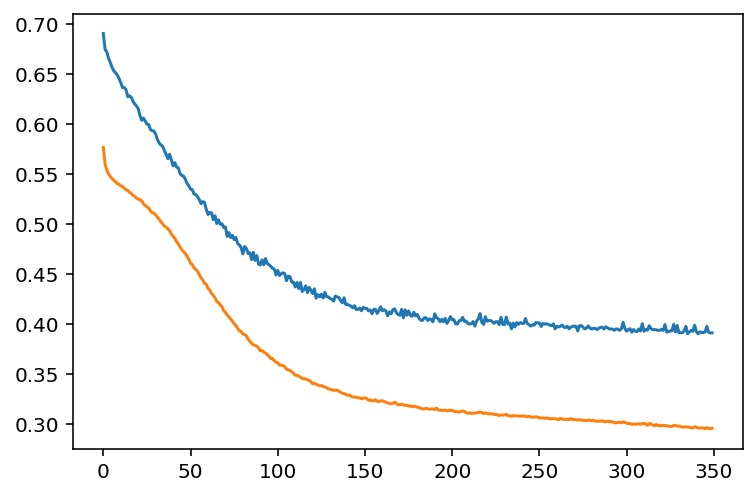

In [582]:
plt.plot(np.concatenate((val_loss_wd,val_loss_wd2, val_loss_wd3)))
plt.plot(np.concatenate((train_loss_wd, train_loss_wd2, train_loss_wd3)))

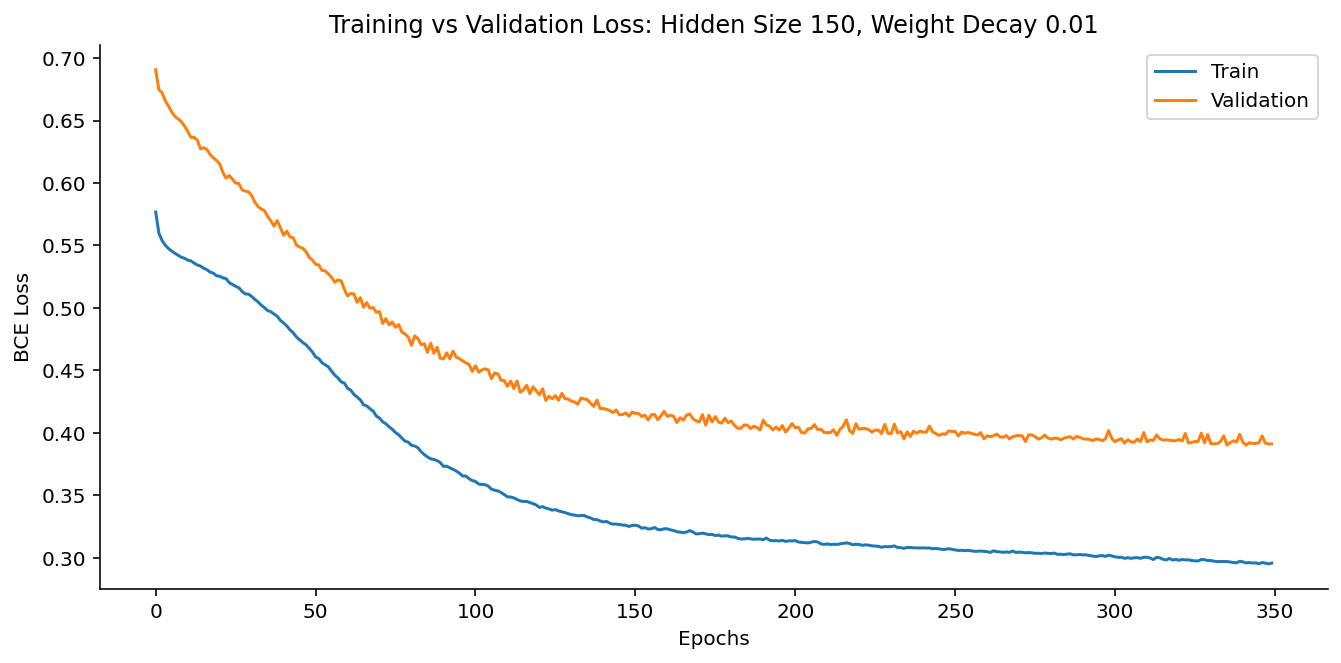

In [584]:
fig, ax = plt.subplots(figsize=(11,5))
ax.plot(np.concatenate((train_loss_wd, train_loss_wd2, train_loss_wd3)), label = 'Train')
ax.plot(np.concatenate((val_loss_wd,val_loss_wd2, val_loss_wd3)), label = 'Validation')
ax.set_title('Training vs Validation Loss: Hidden Size 150, Weight Decay 0.01')
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_xlabel('Epochs')
ax.set_ylabel('BCE Loss')
ax.legend()
plt.show()

### `Results`

> - 57.1532% decrease in training loss from baseline
> - 43.8139% decrease in validation loss from baseline